In [1]:
import numpy as np
import pandas as pd
# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns
%load_ext autoreload
#%autoreload 2

In [2]:
df = pd.read_csv('p2-arbres-fr.csv', delimiter = ';')

In [4]:
if 'type_emplacement' in df.columns:
    df.drop(columns=['type_emplacement', 'numero', 'id_emplacement', 'complement_addresse'], inplace=True)
    df.variete = df.variete.fillna('Manquante')
    df['variete'] = df['variete'].apply(lambda x: x[:-1] if x.endswith("'") else x)
    df_brut = df.copy()
    # debatable
    df = df.dropna(subset=['domanialite'])
    df.remarquable = df.remarquable.apply(lambda x : 1 if x == 1 else 0)

    
    
    hauteur_reccord = 31
    circonference_reccord = 700

    df_sans_outlier_hauteur = df.loc[df.hauteur_m <= hauteur_reccord, :]
    df_sans_outlier = df_sans_outlier_hauteur.loc[df_sans_outlier_hauteur.circonference_cm <= circonference_reccord, :]
    df_sans_outlier.head()

1.***Analyses***

* Taux d\'arbre remarquable pour les 10 genres d\'arbres les plus plantés dans Paris

In [25]:
remarquable_per_genre_df = df.groupby(['genre'])['remarquable'].sum().sort_values(ascending=False)
remarquable_per_genre_df = remarquable_per_genre_df[remarquable_per_genre_df>=5]
temp_serie = df[df['genre'].isin(remarquable_per_genre_df[remarquable_per_genre_df > 0].index)]\
.genre.value_counts().sort_values(ascending=False)
print('Taux d\'arbre remarquable pour les 10 genres d\'arbres les plus plantés dans Paris')

percentage_remarquable_df = pd.DataFrame(remarquable_per_genre_df.div(temp_serie)*100, columns = ['%'],\
             index=temp_serie.sort_values(ascending=False).index).head(10)
percentage_remarquable_df["nombre d'arbre par genre"] = temp_serie
percentage_remarquable_df["nombre d'arbre remarquable par genre"] = remarquable_per_genre_df

percentage_remarquable_df


Taux d'arbre remarquable pour les 10 genres d'arbres les plus plantés dans Paris


,%,nombre d'arbre par genre,nombre d'arbre remarquable par genre
Platanus,0.075133,42591,32
Aesculus,0.039462,25341,10
Acer,0.032483,18471,6
Quercus,0.282995,3887,11
Corylus,0.202137,3463,7
Fagus,0.622084,1929,12
Pterocarya,0.700000,1000,7
Ginkgo,0.851064,940,8
Cedrus,0.878156,911,8
Diospyros,4.000000,150,6


L'échantillon étant très faible, le maximum d'arbre remarquable par genre d'arbre étant 32 platanes, si on veut maximiser les chances de produires des arbres remarquable à Paris il peut être intéressant de planter l'un de ces genres d'abres qui ne sont pas des cas isolés (au moins 5 instances d'arbre remarquable recensés).


On ne peut pas se contenter de dire qu'il faut planter un maximum de Diospyros pour maximiser ces chances, les Platanus, les Quercus et les Fagus semblent semblent être préférable car l'échantillon d'arbre de ces genres présent à Paris est important et ils sont qualifiés de remarquables à une fréquence intéressante.

* Domanialite / genre

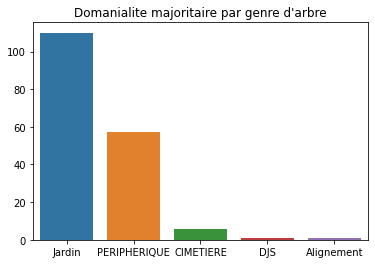

In [40]:
max_values_dict = {genre: max_value for genre, max_value in df.groupby('genre')['domanialite'].max().items()}
top_dom_per_genre = pd.DataFrame(max_values_dict.items(), columns = ['genre', 'domanialite']).domanialite.value_counts()
sns.barplot(x=top_dom_per_genre.index, y=top_dom_per_genre.values)
plt.title("Domanialite majoritaire par genre d'arbre")
plt.show()